## Part 1 - Test Collection Preparation 20 points

* Define and describe a hypothesis of what you are going to do and why it makes sense (you are free to choose what you do, except for re-using the simple baseline unchanged, it is ok to also drop queries altogether if argued and shown why)
* Implement an algorithm that aggregates raw judgements to labels (either 4-grades or binary) in src/judgement_aggregation.py
* Analyze the results of the aggregation, by randomly(!) picking some examples and conducting a meta-judgement of the raw-judgements + the quality of the aggregations based on the text contents of query and passage
* Describe your results in the report, use your labels for evaluation in part 2

## Thinking aloud
We have judgements about pairs of documents and quries. We need to find the way of aggregaring those judgements into a single label per pair. We have some information about judgements, such as user-id, time-to-annotate, time-of-day, judgement-value and selection-of-relevant-characters-span.

Labels for sparse retrieval are important as we will use them as ground truth for model training! At this step we define the optimal strategy to obtain labels from judgements. 

Context:
* We have a majority voting baseline, that aggregates the judgement values with a heuristic to take the higher grade if we have a tie.
* We have a sparse retrieval problem, meaning, that we have only a few (< 3) of examples of relevant documents for each query.

We need to:
* ... find a more sophisticated method for aggregating the judgements
* ... to implement the algorithm to label judgements, that suggests either binary scores (relevant/non-relevant) or 4 grades
* ... perform the error analysis with random sampling to verify the quality of the algorithm, conduct meta-judgement of the raw judgements
* ... describe experiments and results in a section of the report


## Data exploration

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

In [3]:
df_baseline = pd.read_csv('../data/Part-1/fira-22.baseline-qrels.tsv', sep=' ')
df_documents = pd.read_csv('../data/Part-1/fira-22.documents.tsv', sep='\t')
df_queries = pd.read_csv('../data/Part-1/fira-22.queries.tsv', sep='\t')
df_raw_judgements = pd.read_csv('../data/Part-1/fira-22.judgements-anonymized.tsv', sep='\t') 
df_baseline.columns = ['query_id', 'Q0', 'doc_id', 'relevance_class']
df_raw_judgements.columns = ['id', 'relevance_class', 'relevance_character_ranges', 'duration_to_judge', 'judged_at', 'doc_id', 'query_id', 'user_id']

In [4]:
df_raw_judgements.head(5)

,id,relevance_class,relevance_character_ranges,duration_to_judge,judged_at,doc_id,query_id,user_id
0,1,2_GOOD_ANSWER,<no ranges selected>,15712,1648481149,rob_FBIS3-10909,rob_q_FBIS3-10909,User_0
1,2,0_NOT_RELEVANT,<no ranges selected>,160000,1648481336,rob_FBIS3-10383,rob_q_FT941-8917,User_0
2,3,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,<no ranges selected>,16699,1648481352,rob_FBIS3-10722,rob_q_FBIS3-32394,User_0
3,4,2_GOOD_ANSWER,<no ranges selected>,3442,1648481339,rob_FBIS3-11360,rob_q_FBIS3-11360,User_1
4,5,2_GOOD_ANSWER,<no ranges selected>,15849,1648481354,rob_FBIS3-11056,rob_q_FBIS3-11617,User_1


In [5]:
print("Number of judgements: ", df_raw_judgements.shape[0])
print("Number of unique queries: ", df_raw_judgements['query_id'].nunique())
print("Number of unique documents: ", df_raw_judgements['doc_id'].nunique())
print("Number of query-document pairs: ", df_raw_judgements.groupby(by = ['query_id', 'doc_id']).count()['id'].count())
print("Number of users: ", df_raw_judgements['user_id'].nunique())

Number of judgements:  67224
Number of unique queries:  4175
Number of unique documents:  21190
Number of query-document pairs:  24189
Number of users:  152


## Exploratory Data Analysis

<AxesSubplot:ylabel='relevance_class'>

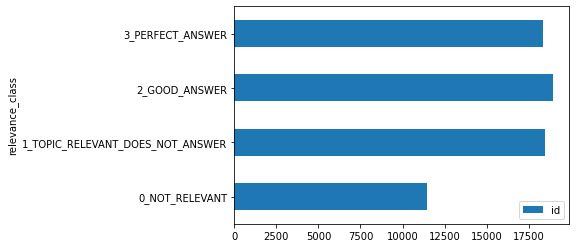

In [6]:
# judgements per relevance class
df_raw_judgements.groupby(by = ['relevance_class']).count()['id'].reset_index().plot(kind='barh', x='relevance_class')

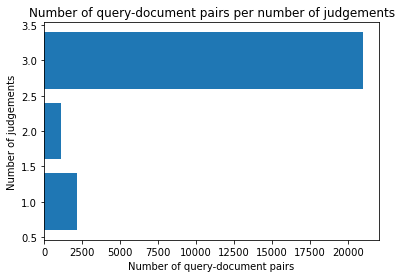

In [7]:
# number of query-document pairs per number of judgements
counts = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).count()['id'].reset_index().groupby(by = ['id']).count()['query_id'].reset_index()
plt.barh(counts['id'], counts['query_id'])
plt.title('Number of query-document pairs per number of judgements')
plt.xlabel('Number of query-document pairs')
plt.ylabel('Number of judgements')
plt.show()

Text(0, 0.5, 'Document count')

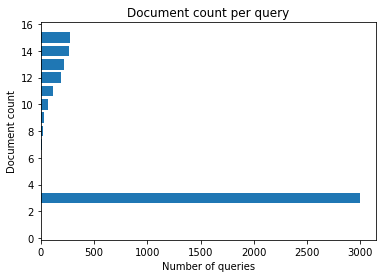

In [8]:
# documents per query
counts = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).count()['id'].reset_index().groupby(by = ['query_id']).count()['doc_id'].reset_index().groupby(by = ['doc_id']).count()['query_id'].reset_index()
plt.barh(counts['doc_id'], counts['query_id'])
plt.title('Document count per query')
plt.xlabel('Number of queries')
plt.ylabel('Document count')

## Analysis of the relevance classes

In [9]:
mapping_relevance = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 0,
    '2_GOOD_ANSWER': 1,
    '3_PERFECT_ANSWER': 1
}

def is_contradictory(judgements, mapping_relevance):
    """
    Return 1 if the judgements are contradictory, 0 otherwise. 
    Contradictory judgements are judgements where both relevant and non-relevant relevance classes were assigned to the pairs.
    """
    judgements_binary = list(judgements['relevance_class'].map(mapping_relevance))
    return int(0 in judgements_binary and 1 in judgements_binary)

flag_is_contradictory = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(lambda x: is_contradictory(x, mapping_relevance)).reset_index()

In [10]:
def get_binary_relevance(judgements, mapping_relevance):
    return judgements['relevance_class'].map(mapping_relevance).value_counts().idxmax()

flag_binary_relevance = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(lambda x: get_binary_relevance(x, mapping_relevance)).reset_index()

def has_majority(judgements):
    """
    Returns 1 if majority was achieved, 0 otherwise.
    """
    if len(judgements) == 1:
        return 1
    elif len(judgements) == 2:
        # check if both judgements are the same
        return int(judgements['relevance_class'].nunique() == 1)
    else:
        # check if the majority is at least 2
        return int(judgements['relevance_class'].value_counts().max() >= 2)
    
flag_has_majority = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(lambda x: has_majority(x)).reset_index()

def is_unanimoous(judgements):
    """
    Returns 1 if all judgements are the same, 0 otherwise.
    """
    if len(judgements) == 1:
        return 1
    elif len(judgements) == 2:
        # check if both judgements are the same
        return int(judgements.nunique() == 1)
    else:
        # check if all judgements are the same
        return int(judgements.nunique() == 1)

flag_is_unanimoous = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(lambda x: is_unanimoous(x['relevance_class'])).reset_index()

weights_relevance = {
    '0_NOT_RELEVANT': 1,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 10,
    '2_GOOD_ANSWER': 100,
    '3_PERFECT_ANSWER': 1000
}

def normalized_weighted_relevance_score(judgements, weights_relevance):
    judgements['relevance_score'] = judgements['relevance_class'].map(weights_relevance)
    return np.log((np.product(judgements['relevance_score']) + 1) / len(judgements))

score_relevance = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(lambda x: normalized_weighted_relevance_score(x, weights_relevance)).reset_index() 


In [11]:
df_pairs = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).count()['id'].reset_index()
df_pairs = df_pairs.merge(flag_is_contradictory, on=['query_id', 'doc_id'])
df_pairs = df_pairs.merge(flag_binary_relevance, on=['query_id', 'doc_id'])
df_pairs = df_pairs.merge(score_relevance, on=['query_id', 'doc_id'])
df_pairs = df_pairs.merge(flag_has_majority, on=['query_id', 'doc_id'])
df_pairs = df_pairs.merge(flag_is_unanimoous, on=['query_id', 'doc_id'])
df_pairs.columns = ['query_id', 'doc_id', 'judgement_count', 'contradictory', 'relevant', 'relevance_score', 'has_majority', 'is_unanimoous']

df_pairs['contradictory_text'] = df_pairs['contradictory'].map({0: 'non-contradictory', 1: 'contradictory'})
df_pairs['relevant_text'] = df_pairs['relevant'].map({0: 'non-relevant', 1: 'relevant'})
df_pairs['relevance_score_minmax'] = (df_pairs['relevance_score'] - df_pairs['relevance_score'].min()) / (df_pairs['relevance_score'].max() - df_pairs['relevance_score'].min())
df_pairs['has_majority_text'] = df_pairs['has_majority'].map({0: 'no majority', 1: 'has majority'})
df_pairs['unanimous_text'] = df_pairs['is_unanimoous'].map({0: 'not unanimous', 1: 'unanimous'})

## Analysis of agreement between judgements

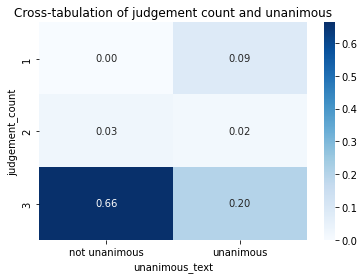

In [12]:
# Comment: 69% of the pairs are non-unanimous! It means that we need an efficient way of resolving the contradictions.
# --------------------------------------------------------------

cross_tab = pd.crosstab(df_pairs['judgement_count'], df_pairs['unanimous_text'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of judgement count and unanimous')
plt.show()

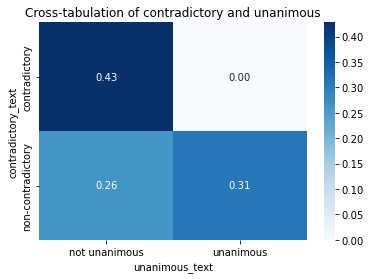

In [13]:
# Comment: 43% of the pairs are contradictory! We need to resolve the contradictions as it could significnatly affect the performance of the system.
# --------------------------------------------------------------

cross_tab = pd.crosstab(df_pairs['contradictory_text'], df_pairs['unanimous_text'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of contradictory and unanimous')
plt.show()

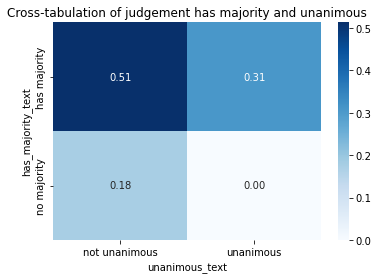

In [14]:
# Comment: 18% of the pairs majority was not achieved. Which means that 
# --------------------------------------------------------------

cross_tab = pd.crosstab(df_pairs['has_majority_text'], df_pairs['unanimous_text'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of judgement has majority and unanimous')
plt.show()

We want to minimize the false negatives, so we want to eliminate situations, when we aren't sure about the relevance of the document. We aren't sure, when document has contradictive votes and doesn't have majority.

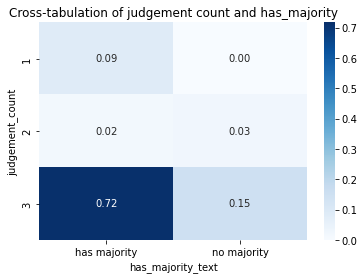

In [15]:
# Comment: In 18% of the pairs majority was not achieved. Most problematic cases.
# --------------------------------------------------------------

cross_tab = pd.crosstab(df_pairs['judgement_count'], df_pairs['has_majority_text'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of judgement count and has_majority')
plt.show()

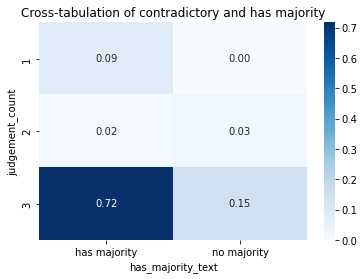

In [16]:
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of contradictory and has majority')
plt.show()

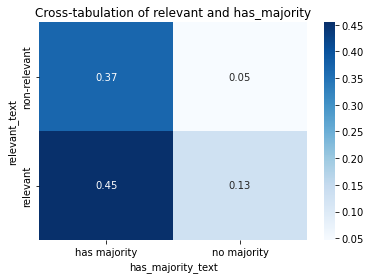

In [17]:
cross_tab = pd.crosstab(df_pairs['relevant_text'], df_pairs['has_majority_text'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of relevant and has_majority')
plt.show()


In [18]:
df_pairs.head(5)

,query_id,doc_id,judgement_count,contradictory,relevant,relevance_score,has_majority,is_unanimoous,contradictory_text,relevant_text,relevance_score_minmax,has_majority_text,unanimous_text
0,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:...That's_the_Way_It_Is>,3,0,1,17.322068,1,0,non-contradictory,relevant,0.885044,has majority,not unanimous
1,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,3,0,0,3.516508,1,0,non-contradictory,non-relevant,0.195804,has majority,not unanimous
2,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:Old_Dirt_Road>,3,0,0,1.299283,1,0,non-contradictory,non-relevant,0.085109,has majority,not unanimous
3,db_q_<dbpedia:.hn>,db_<dbpedia:.hn>,3,1,1,10.414323,0,0,contradictory,relevant,0.540176,no majority,not unanimous
4,db_q_<dbpedia:.hn>,db_<dbpedia:Culture_of_Honduras>,3,0,0,5.810142,1,1,non-contradictory,non-relevant,0.310313,has majority,unanimous


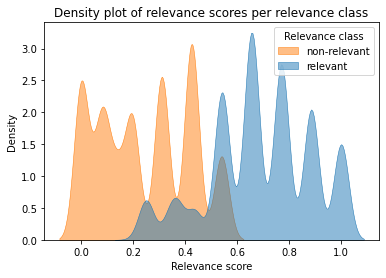

In [19]:
# plot kde plot of relevance scores per relevance class
sns.kdeplot(df_pairs['relevance_score_minmax'], hue=df_pairs['relevant_text'], fill=True, common_norm=False, alpha=0.5, linewidth=0.5)
plt.title('Density plot of relevance scores per relevance class')
plt.xlabel('Relevance score')
plt.ylabel('Density')
# add legend
plt.legend(title='Relevance class', loc='upper right', labels=['non-relevant', 'relevant'])

plt.show()


<AxesSubplot:ylabel='relevant_text,contradictory_text'>

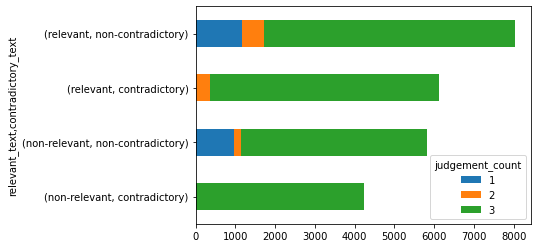

In [20]:
# plot number of pairs with contradictory judgements vs majority aggregation
df_pairs.groupby(by = ['relevant_text', 'contradictory_text', 'judgement_count']).count()['query_id'].unstack().plot(kind='barh', stacked=True)


In [21]:
# define custom aggregation function for judgement aggregation
def majority_voting_agg(judgements):
    return judgements['relevance_class'].value_counts().idxmax()

# aggregate judgements
df_aggregated_judgements = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(majority_voting_agg).reset_index()
df_aggregated_judgements

,query_id,doc_id,0
0,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:...That's_the_Way_It_Is>,3_PERFECT_ANSWER
1,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,1_TOPIC_RELEVANT_DOES_NOT_ANSWER
2,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:Old_Dirt_Road>,0_NOT_RELEVANT
3,db_q_<dbpedia:.hn>,db_<dbpedia:.hn>,2_GOOD_ANSWER
4,db_q_<dbpedia:.hn>,db_<dbpedia:Culture_of_Honduras>,1_TOPIC_RELEVANT_DOES_NOT_ANSWER
...,...,...,...
24184,trip_9999,trip_9337525,2_GOOD_ANSWER
24185,trip_9999,trip_9337888,3_PERFECT_ANSWER
24186,trip_9999,trip_9353917,3_PERFECT_ANSWER
24187,trip_9999,trip_9363894,2_GOOD_ANSWER


In [22]:
df_raw_judgements.head(5)

,id,relevance_class,relevance_character_ranges,duration_to_judge,judged_at,doc_id,query_id,user_id
0,1,2_GOOD_ANSWER,<no ranges selected>,15712,1648481149,rob_FBIS3-10909,rob_q_FBIS3-10909,User_0
1,2,0_NOT_RELEVANT,<no ranges selected>,160000,1648481336,rob_FBIS3-10383,rob_q_FT941-8917,User_0
2,3,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,<no ranges selected>,16699,1648481352,rob_FBIS3-10722,rob_q_FBIS3-32394,User_0
3,4,2_GOOD_ANSWER,<no ranges selected>,3442,1648481339,rob_FBIS3-11360,rob_q_FBIS3-11360,User_1
4,5,2_GOOD_ANSWER,<no ranges selected>,15849,1648481354,rob_FBIS3-11056,rob_q_FBIS3-11617,User_1


## Analysis of annotators' behaviour

In [23]:
# get agreement score for each user
# for each user, get the proportion of pairs where a user agrees with the majority

mapping_relevance = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 1,
    '2_GOOD_ANSWER': 2,
    '3_PERFECT_ANSWER': 3
}

def has_majority_coannot(judgements):
    has_majority = 0
    if len(judgements['relevance_class_coannot']) == 1:
        has_majority = 1
    elif len(judgements['relevance_class_coannot']) == 2:
        # check if both judgements are the same
        has_majority = int(judgements['relevance_class_coannot'].nunique() == 1)
    else:
        # check if the majority is at least 2
        has_majority = int(judgements['relevance_class_coannot'].value_counts().max() >= 2)
    return has_majority
    
def has_alignment_with_majority(judgements):
    annot_relevance_class = judgements['relevance_class_annot'].value_counts().idxmax()
    coannot_relenvance_class = judgements['relevance_class_coannot'].value_counts().idxmax()
    aligns_with_majority = annot_relevance_class == coannot_relenvance_class
    return int(aligns_with_majority)

def get_agreement_score(df_judgements):
    # get unique users
    annotators = df_judgements['user_id'].unique()
    # get all documents labeled by user
    total_pairs_with_majority = 0
    total_pairs_with_alignment = 0
    total_pairs_with_majority_and_alignment = 0
    total_pairs = 0
    df_user_agreement = pd.DataFrame(columns=['user_id', 'agreement_score', 'has_majority', 'has_alignment', 'has_majority_and_alignment', 'total_pairs'])
    for annotator in annotators:
        # get all judgements labeled by user
        df_annot_judgements = df_judgements[df_judgements['user_id'] == annotator]
        df_coannot_judgements = df_judgements[['query_id', 'doc_id', 'user_id', 'relevance_class']].merge(df_annot_judgements[['query_id', 'doc_id', 'user_id', 'relevance_class']], on=['query_id', 'doc_id'], suffixes=('_coannot', '_annot'))
        df_coannot = df_coannot_judgements.groupby(by = ['query_id', 'doc_id']).count().reset_index()

        df_coannot['has_majority'] = df_coannot_judgements.groupby(by = ['query_id', 'doc_id']).apply(has_majority_coannot).reset_index()[0]
        df_coannot['alignment_with_majority'] = df_coannot_judgements.groupby(by = ['query_id', 'doc_id']).apply(has_alignment_with_majority).reset_index()[0]
        df_coannot['has_majority_and_alignment'] = df_coannot['has_majority'] & df_coannot['alignment_with_majority']
        
        total_pairs_with_majority += df_coannot['has_majority'].sum()
        total_pairs_with_alignment += df_coannot['alignment_with_majority'].sum()
        total_pairs_with_majority_and_alignment += df_coannot['has_majority_and_alignment'].sum()
        total_pairs += df_annot_judgements.shape[0]

        agreement_score_user = df_coannot['has_majority_and_alignment'].sum() / df_coannot['has_majority'].sum()
        user_row = {'user_id': annotator,
                   'agreement_score': agreement_score_user,
                   'has_majority': df_coannot['has_majority'].sum(),
                   'has_alignment': df_coannot['alignment_with_majority'].sum(),
                   'has_majority_and_alignment': df_coannot['has_majority_and_alignment'].sum(),
                   'total_pairs': df_annot_judgements.shape[0], 
                   }
        df_user_agreement = df_user_agreement.append(user_row, ignore_index=True)

        print(df_coannot.shape)
        print(user_row)
        
    return df_user_agreement, total_pairs_with_majority, total_pairs_with_alignment, total_pairs_with_majority_and_alignment, total_pairs

# q1 - d1 (j1 - a1, j2 - a4, j3 - a5), d2 (j4, j5, j6), d3 (j7, j8, j9);


df_user_agreement, total_pairs_with_majority, total_pairs_with_alignment, total_pairs_with_majority_and_alignment, total_pairs = get_agreement_score(df_raw_judgements)

(1372, 9)
{'user_id': 'User_0', 'agreement_score': 0.7793983591613491, 'has_majority': 1097, 'has_alignment': 939, 'has_majority_and_alignment': 855, 'total_pairs': 1372}
(9, 9)
{'user_id': 'User_1', 'agreement_score': 0.6666666666666666, 'has_majority': 9, 'has_alignment': 6, 'has_majority_and_alignment': 6, 'total_pairs': 9}
(300, 9)
{'user_id': 'User_2', 'agreement_score': 0.765625, 'has_majority': 256, 'has_alignment': 226, 'has_majority_and_alignment': 196, 'total_pairs': 300}
(601, 9)
{'user_id': 'User_3', 'agreement_score': 0.6955602536997886, 'has_majority': 473, 'has_alignment': 352, 'has_majority_and_alignment': 329, 'total_pairs': 601}
(701, 9)
{'user_id': 'User_4', 'agreement_score': 0.7855946398659966, 'has_majority': 597, 'has_alignment': 512, 'has_majority_and_alignment': 469, 'total_pairs': 701}
(601, 9)
{'user_id': 'User_5', 'agreement_score': 0.811088295687885, 'has_majority': 487, 'has_alignment': 431, 'has_majority_and_alignment': 395, 'total_pairs': 601}
(400, 9)
{

In [24]:
def relevance_present(judgements):
    return judgements[judgements['relevance_character_ranges'] != '<no ranges selected>'].shape[0] / judgements.shape[0]

def percentage_relevance_classes(judgements):
    return judgements['relevance_class'].value_counts()

df_relevance_present = df_raw_judgements.groupby(by = ['user_id']).apply(relevance_present).reset_index()
df_percentage_relevance_classes = df_raw_judgements.groupby(by = ['user_id']).apply(percentage_relevance_classes).reset_index()
# long to wide
df_percentage_relevance_classes = df_percentage_relevance_classes.pivot(index='user_id', columns='level_1', values='relevance_class').reset_index()
df_percentage_relevance_classes.fillna(0, inplace=True)
# convert to int
df_percentage_relevance_classes[['0_NOT_RELEVANT', '1_TOPIC_RELEVANT_DOES_NOT_ANSWER', '2_GOOD_ANSWER', '3_PERFECT_ANSWER']] = df_percentage_relevance_classes[['0_NOT_RELEVANT', '1_TOPIC_RELEVANT_DOES_NOT_ANSWER', '2_GOOD_ANSWER', '3_PERFECT_ANSWER']].astype(int)
# normalize by sum of all classes
df_percentage_relevance_classes[['0_NOT_RELEVANT', '1_TOPIC_RELEVANT_DOES_NOT_ANSWER', '2_GOOD_ANSWER', '3_PERFECT_ANSWER']] = df_percentage_relevance_classes[['0_NOT_RELEVANT', '1_TOPIC_RELEVANT_DOES_NOT_ANSWER', '2_GOOD_ANSWER', '3_PERFECT_ANSWER']].div(df_percentage_relevance_classes[['0_NOT_RELEVANT', '1_TOPIC_RELEVANT_DOES_NOT_ANSWER', '2_GOOD_ANSWER', '3_PERFECT_ANSWER']].sum(axis=1), axis=0)

df_users = df_raw_judgements.groupby(by = ['user_id']).agg({'id': 'count', 'duration_to_judge': 'mean'}).reset_index()
df_users['duration_to_judge'] = df_users['duration_to_judge'] / 1000 # convert to seconds
df_users.columns = ['user_id', 'judgements_count', 'mean_duration_to_judge']

# merge
df_users = df_users.merge(df_relevance_present, on='user_id')
df_users = df_users.merge(df_percentage_relevance_classes, on='user_id')
df_users = df_users.merge(df_user_agreement, on='user_id')
# normalize scores with min-max
df_users['agreement_score'] = (df_users['agreement_score'] - df_users['agreement_score'].min()) / (df_users['agreement_score'].max() - df_users['agreement_score'].min())
df_users.drop(columns=[0], inplace=True)

In [25]:
# create quartiles for duration to judge
df_users['mean_duration_to_judge_bins'] = pd.qcut(df_users['mean_duration_to_judge'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
# create quartiles for judgements count
df_users['judgements_count_bins'] = pd.qcut(df_users['judgements_count'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
# create quartiles for agreement score
df_users['agreement_score_bins'] = pd.qcut(df_users['agreement_score'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])


<AxesSubplot:xlabel='agreement_score', ylabel='Count'>

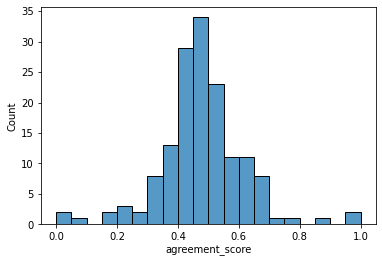

In [26]:
sns.histplot(df_users['agreement_score'], bins = 20)

<AxesSubplot:xlabel='judgements_count', ylabel='Count'>

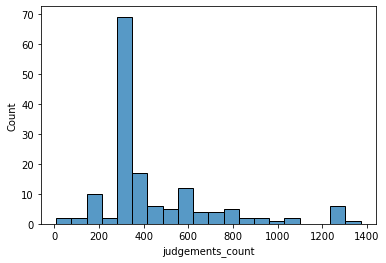

In [27]:
sns.histplot(df_users['judgements_count'],  bins = 20)

<AxesSubplot:xlabel='mean_duration_to_judge', ylabel='Count'>

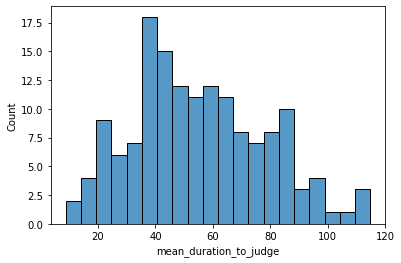

In [28]:
sns.histplot(df_users['mean_duration_to_judge'],  bins = 20)

<AxesSubplot:xlabel='agreement_score_bins', ylabel='mean_duration_to_judge'>

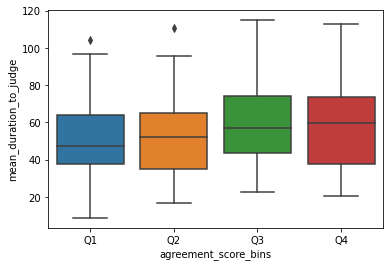

In [29]:
sns.boxplot(x='agreement_score_bins', y='mean_duration_to_judge', data=df_users)
# better annotators take more time to judge!

<AxesSubplot:xlabel='agreement_score_bins', ylabel='judgements_count'>

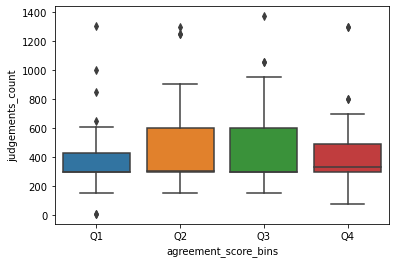

In [30]:
sns.boxplot(x='agreement_score_bins', y='judgements_count', data=df_users)
# no major differences in agreement score based on number of judgements

Text(0.5, 1.0, 'Distribution of relevance classes proportions')

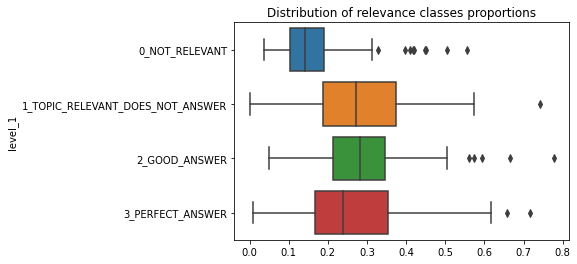

In [31]:
# plot boxplots for 4 columns
sns.boxplot(data=df_percentage_relevance_classes, orient='h')
plt.title('Distribution of relevance classes proportions')

<AxesSubplot:ylabel='Frequency'>

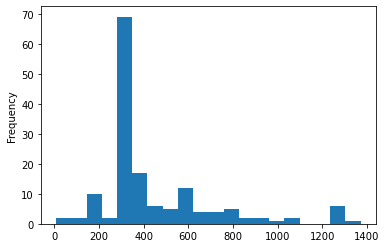

In [32]:
df_user_agreement['total_pairs'].plot(kind = 'hist', bins=20)

## Get weighted judgements based on agreement score of annotators

In [33]:
df_raw_judgements = df_raw_judgements.merge(df_users[['user_id', 'agreement_score']], on='user_id')

In [34]:
# del df_raw_judgements['agreement_score_y']
df_raw_judgements.rename(columns={'agreement_score_x': 'agreement_score'}, inplace=True)

In [35]:
df_raw_judgements['relevance_character_ranges'].value_counts().idxmax()

'<no ranges selected>'

In [36]:
mapping_relevance = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 0,
    '2_GOOD_ANSWER': 1,
    '3_PERFECT_ANSWER': 1
}



def get_weighted_labels(judgements, mapping_relevance):
    judgements_binary = list(judgements['relevance_class'].map(mapping_relevance))
    has_majority = 0
    is_contradictory = int(0 in judgements_binary and 1 in judgements_binary)

    if len(judgements['relevance_class']) == 1:
        has_majority = 1
    elif len(judgements['relevance_class']) == 2:
        # check if both judgements are the same
        has_majority = int(judgements['relevance_class'].nunique() == 1)
    else:
        # check if the majority is at least 2
        has_majority = int(judgements['relevance_class'].value_counts().max() >= 2)
    ranges_provided = {'0_NOT_RELEVANT': 0, '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 0, '2_GOOD_ANSWER': 0, '3_PERFECT_ANSWER': 0}
    for index, row in judgements.iterrows():
        if row['relevance_character_ranges'] != '<no ranges selected>':
            ranges_provided[row['relevance_class']] += 1
    ranges_provided_flag = sum(ranges_provided.values()) > 0

    # get first digit of the string in the column relevance_class
    if has_majority: # majority achieved in judgements: (j1, j1, j1) or (j1, j1, j2)
        if is_contradictory: # if there is a contradiction in judgements [j0, j1] vs [j2, j3]: (j0, j1, j2) or (j1, j3, j3)
            if ranges_provided_flag: # if there are ranges provided, return the relevance class with the highest count of judgements with ranges provided
                return max(ranges_provided, key=ranges_provided.get)
            else: # if there are no ranges provided, return the simple majority - return the simple majority
                return judgements['relevance_class'].value_counts().idxmax() 
        else: # if there is no contradiction in judgements: (j0, j1, j1) or (j2, j2, j2) or (j2, j3, j3) - return the simple majority
            return judgements['relevance_class'].value_counts().idxmax()
    else: # majority not achieved in judgements: (j0, j1, j2) or (j0, j1, j3) - return the agreement weighted majority
        # return judgements.groupby(by = ['relevance_class']).apply(lambda x: x['agreement_score'].sum()/ len(x['agreement_score'])).idxmax()
        return judgements.groupby(by = ['relevance_class']).apply(lambda x: x['agreement_score'].sum()).idxmax()

def get_majority_labels(judgements):
    return judgements['relevance_class'].value_counts().idxmax()


In [178]:
labels_simple_majority = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(get_majority_labels).reset_index()

In [179]:
# do majority voting
labels_weighted_majority = df_raw_judgements.groupby(by = ['query_id', 'doc_id']).apply(lambda x: get_weighted_labels(x, mapping_relevance)).reset_index()

In [180]:
# save labels_weighted_majority as tsv file
labels_weighted_majority.to_csv('../data/Part-1/fira-22.judgements-anonymized-aggregated.tsv', sep='\t', index=False)

In [181]:
# apply dict to map relevance classes to first digit int
labels_weighted_majority.columns = ['query_id', 'doc_id', 'relevance_class']
dict_rel = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 1,
    '2_GOOD_ANSWER': 2,
    '3_PERFECT_ANSWER': 3
}

labels_weighted_majority['relevance_class'] = labels_weighted_majority['relevance_class'].map(dict_rel)

labels_weighted_majority['place_holder'] = 'Q0'

# reorder columns: query_id, place_holder, doc_id, relevance_class

labels_weighted_majority = labels_weighted_majority[['query_id', 'place_holder', 'doc_id', 'relevance_class']]

# save labels_weighted_majority as tsv file
labels_weighted_majority.to_csv('../data/Part-1/fira-22.judgements-anonymized-aggregated_v1.tsv', sep=' ', index=False, header=False)

## Analysis of differences between baseline and weighted

In [182]:
del labels_weighted_majority['place_holder']

In [183]:
df_comparison = labels_simple_majority.merge(labels_weighted_majority, on=['query_id', 'doc_id'])
df_comparison.columns = ['query_id', 'doc_id', 'simple_majority', 'weighted_majority']

map_number = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 1,
    '2_GOOD_ANSWER': 2,
    '3_PERFECT_ANSWER': 3
}

inverted_map_number = {v: k for k, v in map_number.items()}

In [184]:
df_comparison['weighted_majority'] = df_comparison['weighted_majority'].map(inverted_map_number)

In [185]:
df_comparison = df_comparison.merge(df_baseline[['query_id', 'doc_id', 'relevance_class']].rename(columns = {'relevance_class': 'baseline_number'}), on = ['query_id', 'doc_id'])
df_comparison['baseline'] = df_comparison['baseline_number'].map(inverted_map_number)

In [186]:
df_comparison['simple_majority_number'] = df_comparison['simple_majority'].map(map_number).astype(int)
df_comparison['weighted_majority_number'] = df_comparison['weighted_majority'].map(map_number).astype(int)

In [188]:
df_comparison[['weighted_majority', 'simple_majority', 'baseline']]

,weighted_majority,simple_majority,baseline
0,3_PERFECT_ANSWER,3_PERFECT_ANSWER,3_PERFECT_ANSWER
1,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,1_TOPIC_RELEVANT_DOES_NOT_ANSWER
2,0_NOT_RELEVANT,0_NOT_RELEVANT,0_NOT_RELEVANT
3,0_NOT_RELEVANT,2_GOOD_ANSWER,3_PERFECT_ANSWER
4,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,1_TOPIC_RELEVANT_DOES_NOT_ANSWER
...,...,...,...
24183,2_GOOD_ANSWER,2_GOOD_ANSWER,2_GOOD_ANSWER
24184,3_PERFECT_ANSWER,3_PERFECT_ANSWER,3_PERFECT_ANSWER
24185,3_PERFECT_ANSWER,3_PERFECT_ANSWER,3_PERFECT_ANSWER
24186,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,2_GOOD_ANSWER,3_PERFECT_ANSWER


In [191]:

df_comparison['difference_smj_weighted'] = df_comparison['simple_majority'] != df_comparison['weighted_majority']
df_comparison['diff_smj_baseline'] = df_comparison['simple_majority'] != df_comparison['baseline']
df_comparison['diff_baseline_weighted'] = df_comparison['baseline'] != df_comparison['weighted_majority']
print("Difference between simple majority and baseline: ", np.sum(df_comparison['diff_smj_baseline'])/df_comparison.shape[0])
print("Difference between weighted majority and baseline: ", np.sum(df_comparison['diff_baseline_weighted'])/df_comparison.shape[0])
print("Difference between simple majority and weighted majority: ", np.sum(df_comparison['difference_smj_weighted'])/df_comparison.shape[0])

df_comparison = df_comparison.merge(df_pairs, on = ['query_id', 'doc_id'])

Difference between simple majority and baseline:  0.13407474780883083
Difference between weighted majority and baseline:  0.17351579295518438
Difference between simple majority and weighted majority:  0.16483380188523233


In [192]:
df_comparison.shape

(24188, 33)

In [193]:
df_comparison.columns

Index(['query_id', 'doc_id', 'simple_majority', 'weighted_majority',
       'baseline_number', 'baseline', 'simple_majority_number',
       'weighted_majority_number', 'difference_smj_weighted',
       'diff_smj_baseline', 'diff_baseline_weighted', 'judgement_count_x',
       'contradictory_x', 'relevant_x', 'relevance_score_x', 'has_majority_x',
       'is_unanimoous_x', 'contradictory_text_x', 'relevant_text_x',
       'relevance_score_minmax_x', 'has_majority_text_x', 'unanimous_text_x',
       'judgement_count_y', 'contradictory_y', 'relevant_y',
       'relevance_score_y', 'has_majority_y', 'is_unanimoous_y',
       'contradictory_text_y', 'relevant_text_y', 'relevance_score_minmax_y',
       'has_majority_text_y', 'unanimous_text_y'],
      dtype='object')

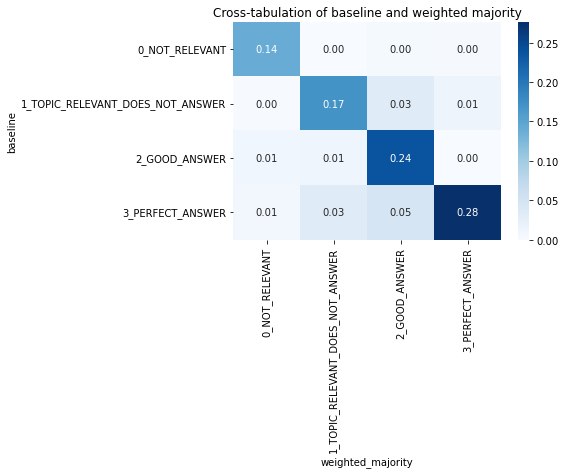

In [195]:
# cross-tab heatmap
cross_tab = pd.crosstab(df_comparison['baseline'], df_comparison['weighted_majority'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of baseline and weighted majority')
plt.show()


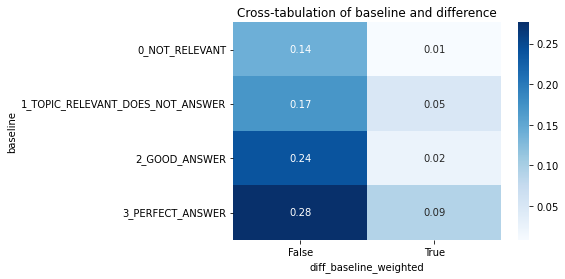

In [196]:
# cross-tab heatmap
cross_tab = pd.crosstab(df_comparison['baseline'], df_comparison['diff_baseline_weighted'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of baseline and difference')
plt.show()


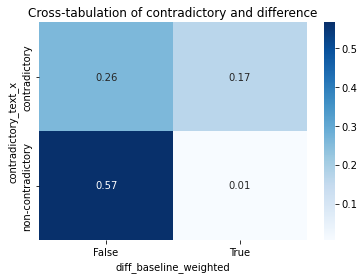

In [201]:
# cross-tab heatmap
cross_tab = pd.crosstab(df_comparison['contradictory_text_x'], df_comparison['diff_baseline_weighted'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of contradictory and difference')
plt.show()


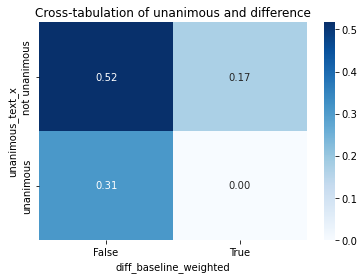

In [202]:
# cross-tab heatmap
cross_tab = pd.crosstab(df_comparison['unanimous_text_x'], df_comparison['diff_baseline_weighted'])
# normalize the values
cross_tab = cross_tab / cross_tab.sum().sum()
# plot heatmap
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap='Blues')
plt.title('Cross-tabulation of unanimous and difference')
plt.show()


In [294]:
# proportion of judgements with provided relevance_character_ranges per relevance class
df_raw_judgements[(df_raw_judgements['relevance_class'] == '3_PERFECT_ANSWER') & (df_raw_judgements['relevance_character_ranges'] != '<no ranges selected>')].shape[0]/df_raw_judgements[(df_raw_judgements['relevance_class'] == '3_PERFECT_ANSWER')].shape[0]

0.4670449585333915

In [71]:
def pretty_print_long_text(text, max_length=70, max_lines=3):
    # split on spaces and add new line after max_length of characters but don't split words
    words = text.split(' ')
    pretty_text = ''
    line_length = 0
    for word in words:
        if line_length + len(word) > max_length:
            pretty_text += '\n'
            line_length = 0
        pretty_text += word + ' '
        line_length += len(word)
        if pretty_text.count('\n') >= max_lines:
            pretty_text += '...'
            break
    return pretty_text

In [73]:
def sample_judgements_based_on_pairs(df_judgements, query_id, doc_id, n_sample, random_state=42):
    return df_judgements[(df_judgements['query_id'] == query_id) & (df_judgements['doc_id'] == doc_id)].sample(n=n_sample, randome_state=random_state).sort_values(by=['query_id', 'doc_id'])

properties_dict = {
    'contradictory': None,
    'has_majority': 0,
    'is_unanimoous': None,
    'diff_baseline_weighted':1
}

condition = ' & '.join([f'{key} == {value}' for key, value in properties_dict.items() if value is not None])
print("Conditioned dataset shape: ", df_comparison.query(condition).shape)
print("Percentage to all rows with difference: ", df_comparison.query(condition).shape[0] / df_comparison[df_comparison['diff_baseline_weighted'] == 1].shape[0])
df_pairs_sample = df_comparison.query(condition).sample(n=10, random_state=67).to_dict(orient='records')

# # get random query_id and get all documents for that query
# query_id = df_comparison['query_id'].sample(n=1, random_state=53).values[0]
# df_pairs_sample_query = df_comparison[df_comparison['query_id'] == query_id].to_dict(orient='records')

# df_pairs_sample = df_pairs[
#                            (df_pairs['contradictory'] == properties_dict['contradictory']) \
#                          & (df_pairs['relevant'] == properties_dict['relevant']) \
#                          & (df_pairs['has_majority'] == properties_dict['has_majority'])
#                         ].sample(n=10, random_state=32)[['query_id', 'doc_id', 'relevance_score']].to_dict(orient='records')



Conditioned dataset shape:  (2815, 22)
Percentage to all rows with difference:  0.6707171789373362


In [75]:
def explore_judgements_per_pair(df_judgements, df_queries, df_documents, df_pairs_sample):
    print("Number of pairs: ", len(df_pairs_sample))
    for pair in df_pairs_sample:
        print(f" Baseline: {pair['baseline']} \n Weighted: {pair['weighted_majority']} \n Contradictory: {pair['contradictory_text']} \n Unanimous: {pair['unanimous_text']} \n Has majority: {pair['has_majority_text']}")
        print(pair)
        # print(f'Baseline: {pair['']}, Weighted: {}, Contradictory: {}, Unanimous: {}, Has majority: {}')
        query_text = df_queries[df_queries['query_id'] == pair['query_id']]['query_text'].values[0]
        document_text = df_documents[df_documents['doc_id'] == pair['doc_id']]['doc_text'].values[0]
        # get all judgements
        print(f'Query: {query_text}')
        print(f'Document: \n {pretty_print_long_text(document_text, max_length=70, max_lines=10)}')
        judgements = df_judgements[(df_judgements['query_id'] == pair['query_id']) & (df_judgements['doc_id'] == pair['doc_id'])].to_dict(orient='records')
        for judgement in judgements:
            # print(f'Relevance class: {judgement["relevance_class"]}')
            print(f'Judgement: {judgement}')
        print('----------------------------------')

explore_judgements_per_pair(df_raw_judgements, df_queries, df_documents, df_pairs_sample)

# explore_judgements_per_pair(df_raw_judgements, df_queries, df_documents, df_pairs_sample_query)


Number of pairs:  10
 Baseline: 3_PERFECT_ANSWER 
 Weighted: 2_GOOD_ANSWER 
 Contradictory: contradictory 
 Unanimous: not unanimous 
 Has majority: no majority
{'query_id': 'trip_159291', 'doc_id': 'trip_10819479', 'simple_majority': '2_GOOD_ANSWER', 'weighted_majority': '2_GOOD_ANSWER', 'difference_smj_weighted': 0, 'simple_majority_number': 2, 'weighted_majority_number': 2, 'baseline_number': 3, 'baseline': '3_PERFECT_ANSWER', 'diff_smj_baseline': True, 'diff_baseline_weighted': True, 'judgement_count': 3, 'contradictory': 1, 'relevant': 1, 'relevance_score': 12.716899269295665, 'has_majority': 0, 'is_unanimoous': 0, 'contradictory_text': 'contradictory', 'relevant_text': 'relevant', 'relevance_score_minmax': 0.6551316346079018, 'has_majority_text': 'no majority', 'unanimous_text': 'not unanimous'}
Query: treatment resistant schizophrenia
Document: 
 electroconvulsive therapy for treatment - resistant schizophrenia . background 
: electroconvulsive therapy ( ect ) involves the induc

In [2]:

df_judg = pd.read_csv('../data/Part-1/fira-22.judgements-anonymized-aggregated_v1.tsv', sep=' ', header=None)

In [3]:
df_judg.columns = ['query_id', 'place_holder', 'doc_id', 'relevance_class']

In [4]:
aggr = df_judg.groupby(by = ['query_id']).count().reset_index().sort_values(by='doc_id', ascending=False)

<AxesSubplot:title={'center':'Number of documents per query in FIRA dataset'}, ylabel='Frequency'>

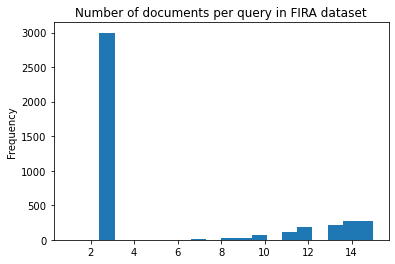

In [9]:
aggr['place_holder'].plot(kind='hist', bins=20, xlabel = 'Number of documents per query', ylabel = 'frequency', title = 'Number of documents per query in FIRA dataset')